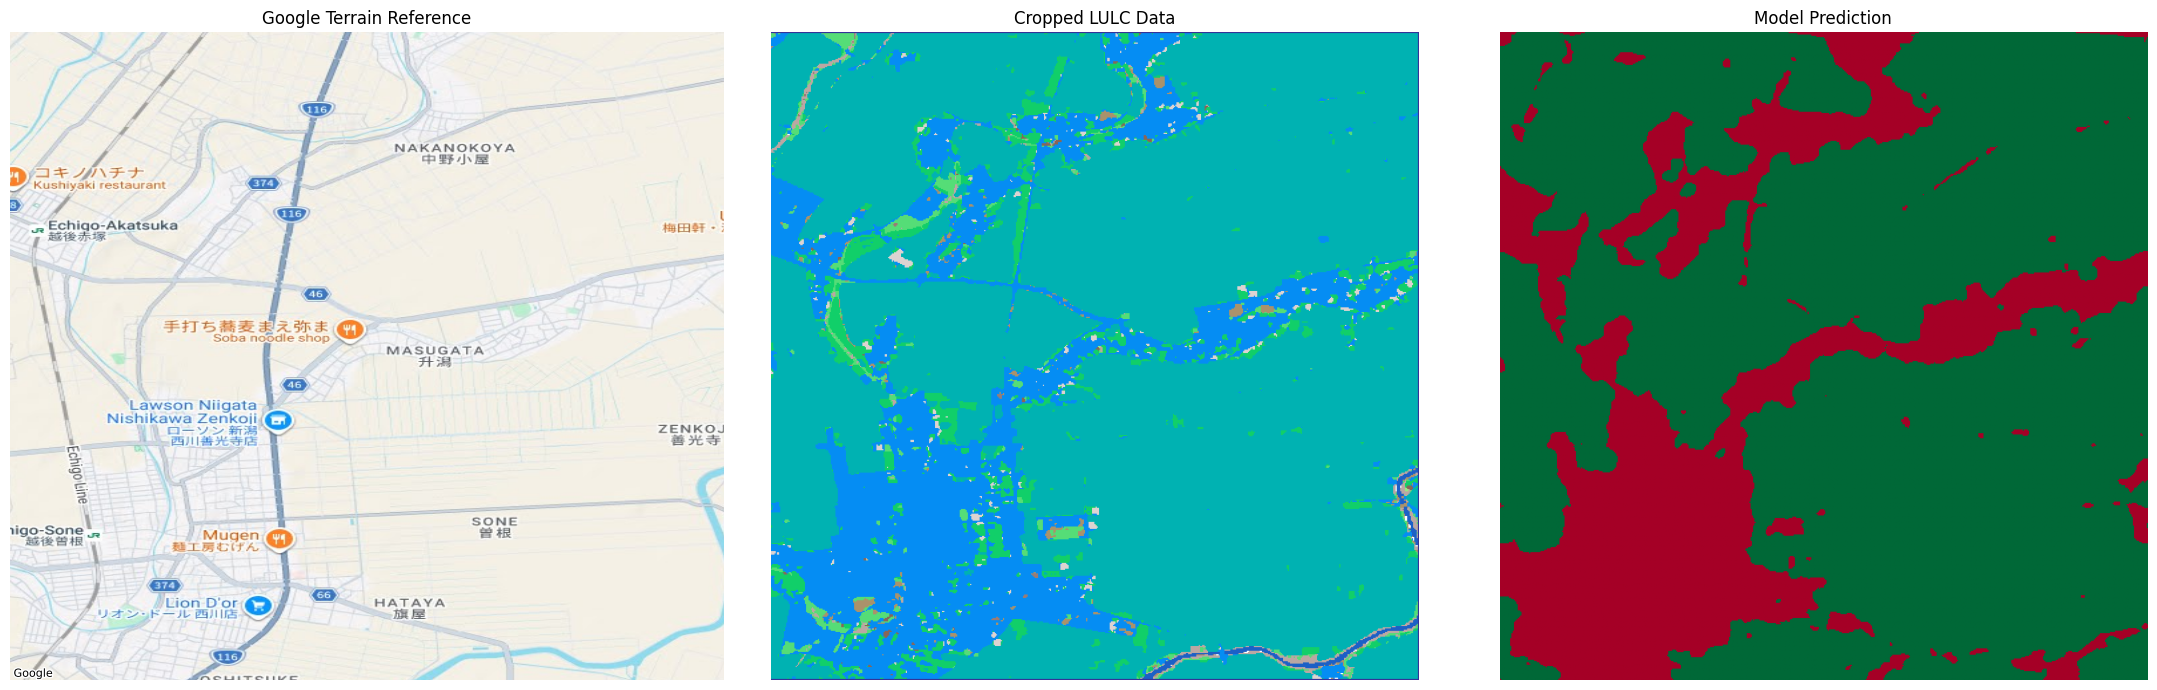

In [1]:
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
from shapely.geometry import box
import xyzservices.lib as xyz

# 1. Setup the Google Terrain Provider explicitly
google_terrain = xyz.TileProvider(
    name="GoogleTerrain",
    url="https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}",
    attribution="Google"
)

# 2. Open the prediction tile and get extent
with rasterio.open(r'G:\data\models\test_2.tif') as src:
    pred_data = src.read(1)
    bbox = src.bounds
    gdf_bounds = gpd.GeoDataFrame({'geometry': [box(*bbox)]}, crs=src.crs)
    # Convert bounds to Web Mercator (EPSG:3857) for contextily
    gdf_3857 = gdf_bounds.to_crs(epsg=3857)
    west, south, east, north = gdf_3857.total_bounds

# 3. Prepare LULC Crop
with rasterio.open(r'C:\Users\venka\workspace\projects\dump\paddy_identification\data\processed\labels\nigata_merge.tif') as lulc_src:
    bounds_for_lulc = gdf_bounds.to_crs(lulc_src.crs)
    lulc_data, _ = rasterio.mask.mask(lulc_src, bounds_for_lulc.geometry, crop=True)
    lulc_data = lulc_data[0]

# 4. Create the 3-Panel Plot
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# --- Panel 1: Google Terrain ---
axes[0].set_title("Google Terrain Reference")

# Set the limits in 3857 coordinates
axes[0].set_xlim(west, east)
axes[0].set_ylim(south, north)

# Force the specific Google provider
cx.add_basemap(axes[0], source=google_terrain)

# --- Panel 2: LULC ---
# Note: LULC and Prediction usually look better in their native CRS (meters/degrees)
axes[1].set_title("Cropped LULC Data")
axes[1].imshow(lulc_data, extent=[bbox.left, bbox.right, bbox.bottom, bbox.top], cmap='terrain')

# --- Panel 3: Prediction ---
axes[2].set_title("Model Prediction")
axes[2].imshow(pred_data, extent=[bbox.left, bbox.right, bbox.bottom, bbox.top], cmap='RdYlGn')

for ax in axes:
    ax.set_axis_off()

plt.tight_layout()
plt.show()